# Purpose of Notebook
This notebook explroes some baseline classifiers to classify user in my tweet data set as either democrat or republican.

# Read Data

In [1]:
import pandas as pd

tweets_df = pd.read_csv('../data/us_politician_tweets.csv')

C:\Users\Gustav\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Split Data
I want to set aside validation and test sets. Tweets by a single user should be isolated to a single data set.

In [10]:
import numpy as np

def split_party_authors(df):
    author_tweets = df.groupby('twitter_id')
    author_tweets = author_tweets.count()
    author_tweets['cumsum'] = author_tweets['tweet'].cumsum()
    author_tweets['%'] = author_tweets['cumsum'] / author_tweets['tweet'].sum()
    
    train_id = np.argmax(author_tweets['%'].values >= .7)
    val_id = np.argmax(author_tweets['%'].values >= .85)
    
    train_authors = list(author_tweets.iloc[:train_id].index.values)
    val_authors = list(author_tweets.iloc[train_id:val_id].index.values)
    test_authors = list(author_tweets.iloc[val_id:].index.values)
    
    return train_authors, val_authors, test_authors

def split_data(df):
    
    democrat_df = df[df['party'] == 'democrat']
    republican_df = df[df['party'] == 'republican']
    
    democrat_train, democrat_val, democrat_test = split_party_authors(democrat_df)
    republican_train, republican_val, republican_test = split_party_authors(republican_df)
    
    train_authors = democrat_train + republican_train
    val_authors = democrat_val + republican_val
    test_authors = democrat_test + republican_test
    
    return df.loc[df['twitter_id'].apply(lambda x: x in train_authors)], df.loc[df['twitter_id'].apply(lambda x: x in val_authors)], df.loc[df['twitter_id'].apply(lambda x: x in test_authors)]
    

In [11]:
train_df, val_df, test_df = split_data(tweets_df)

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set()
sns.set_style('whitegrid')

C:\Users\Gustav\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


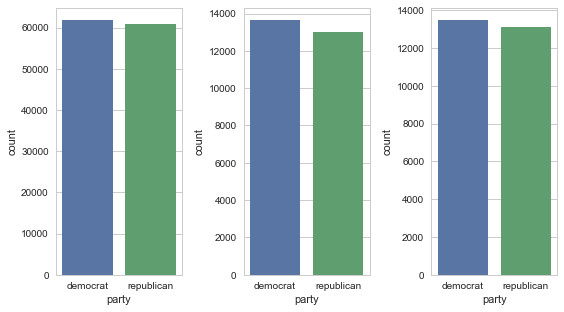

In [13]:
f, ax = plt.subplots(1, 3, figsize=(8,4.5))

sns.countplot('party', data=train_df, ax=ax[0])
sns.countplot('party', data=val_df, ax=ax[1])
sns.countplot('party', data=test_df, ax=ax[2])

f.tight_layout()

Democrat and republican tweets are evenly split among data sets, and authors are isolated to single sets.

## Shuffle Data

In [16]:
train_df = train_df.sample(frac=1)
val_df = val_df.sample(frac=1)
test_df = test_df.sample(frac=1)

# Pre-process Data

In [17]:
vocab = {}

In [27]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [28]:
stopwords = set(stopwords.words())

In [29]:
import re

def process_tweet(tweet):
    
    # Lower Case
    tweet = tweet.lower()
    
    # Remove concluding URL
    tweet = re.sub(r' *https:\/\/t.co\/\w+$', '', tweet)
    
    # Replace other URLs with url tag
    tweet = re.sub(r'https?:$', '', tweet)
    
    # Replace carriage return and linebrak with space
    tweet = re.sub(r'[\r\n]', ' ', tweet)
    
    # Remove emoticons
    tweet = re.sub(r'&amp;', '', tweet)
    
    # Remove punctuation
    tweet = re.sub(r'[.,:;?!"]', ' ', tweet)
    
    # Tokenize with nltk
    tweet = word_tokenize(tweet)
    
    # Remove
    
    tweet = [tok for tok in tweet if tok != '' and tok not in stopwords]
    
    return tweet

def extend_vocab(tweet):
    tweet = process_tweet(tweet)
    for word in tweet:
        try:
            vocab[word] += 1
        except KeyError:
            vocab[word] = 1

# TF-IDF

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
tfidf = TfidfVectorizer(tokenizer=process_tweet, analyzer='word', max_df=.05, min_df=25)

In [32]:
X_train = tfidf.fit_transform(train_df['tweet'])
y_train = train_df['party'].apply(lambda x: 1 if x == 'democrat' else 0).values

In [33]:
X_val = tfidf.transform(val_df['tweet'])
y_val = val_df['party'].apply(lambda x: 1 if x == 'democrat' else 0).values

In [34]:
X_test= tfidf.transform(test_df['tweet'])
y_test = test_df['party'].apply(lambda x: 1 if x == 'democrat' else 0).values

In [35]:
print("%d words kept in vocabulary" % len(tfidf.vocabulary_))

7309 words kept in vocabulary


# Classification

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score, accuracy_score

def evaluate_model(X, y, model, axs, plot_pr_curve = True):
    
    ax = axs[0]
    pred = model.predict(X)
    
    conf = confusion_matrix(y, pred)
    conf_df = pd.DataFrame(data=conf, columns=['Republican', 'Democrat'], index=['Republican', 'Democrat'])
    sns.heatmap(conf_df, annot=True, cmap="YlGnBu", fmt='d', ax=ax, square=True, cbar=False)
    ax.set_ylabel('Target')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix (Decision Threshold = 0.5)')
    
    ax = axs[1]
    
    if plot_pr_curve:
        proba = model.predict_proba(X)
        proba = proba[:,1]
        precision, recall, thresholds = precision_recall_curve(y, proba)
        accuracy = accuracy_score(y, proba > .5)
        aps = average_precision_score(y, proba)
        idx = np.argmax(thresholds >= .5)
        ax.scatter(recall, precision, s=1)
        ax.scatter(recall[idx], precision[idx], s=100, marker='*', color='r')
        ax.legend(['PR Curve', 'Decision Threshold = 0.5'])
        ax.axis('equal')
        ax.set_ylabel('Precision')
        ax.set_xlabel('Recall')
        ax.set_title('Precision Recall Curve, APS = %.3f, Acc = %.3f' % (aps, accuracy))
        
        ax.set_ylim([0, 1])
        ax.set_xlim([0, 1])
        
    else:
        precision = precision_score(y, pred)
        recall = recall_score(y, pred)
        accuracy = accuracy_score(y, pred)
        df = pd.DataFrame([['Precision', precision], ['Recall', recall]], columns=['Metric', 'Score'])
        sns.barplot(x='Metric', y='Score', data=df, ax=ax)
        ax.set_title('Precision and Recall, Acc = %.3f' % accuracy)
    

## Naive Bayes

### TFIDF

In [37]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes = MultinomialNB()

naive_bayes.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

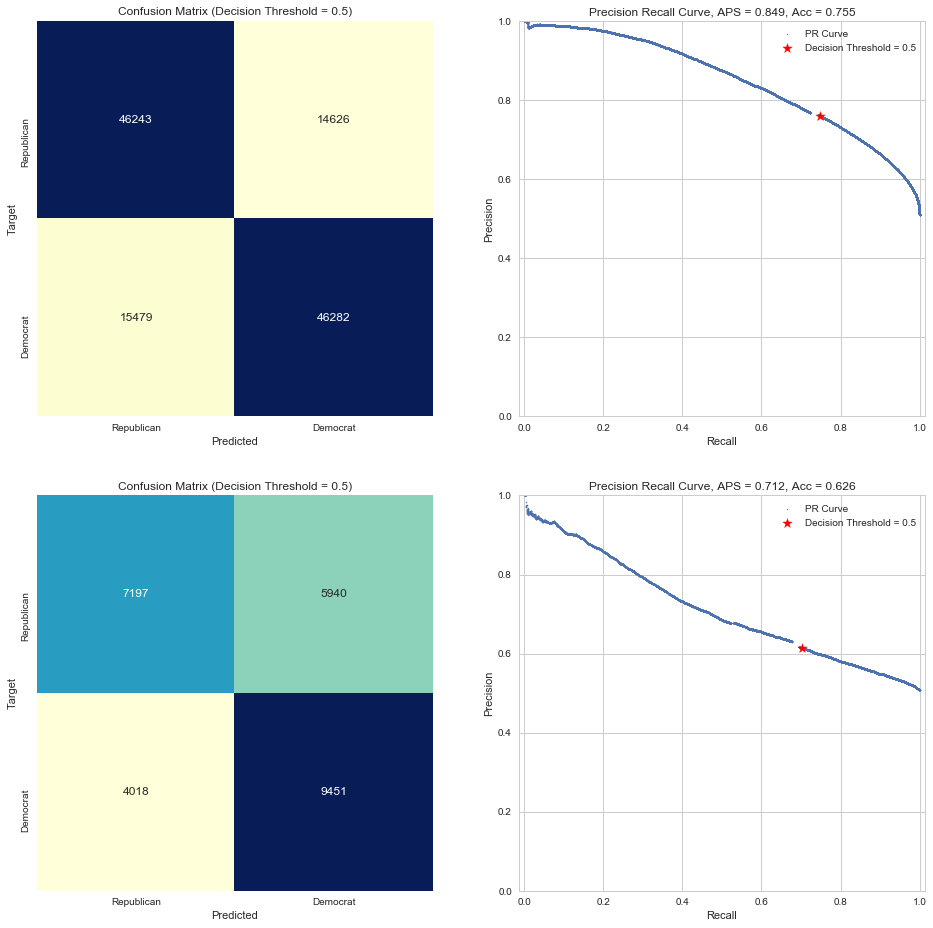

In [38]:
f, ax = plt.subplots(2, 2, figsize=(16,16))
evaluate_model(X_train, y_train, naive_bayes, ax[0])
evaluate_model(X_test, y_test, naive_bayes, ax[1])

# LGBoost

### TFIDF

In [39]:
from lightgbm.sklearn import LGBMClassifier

lgb = LGBMClassifier(class_weight='balanced')

lgb.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

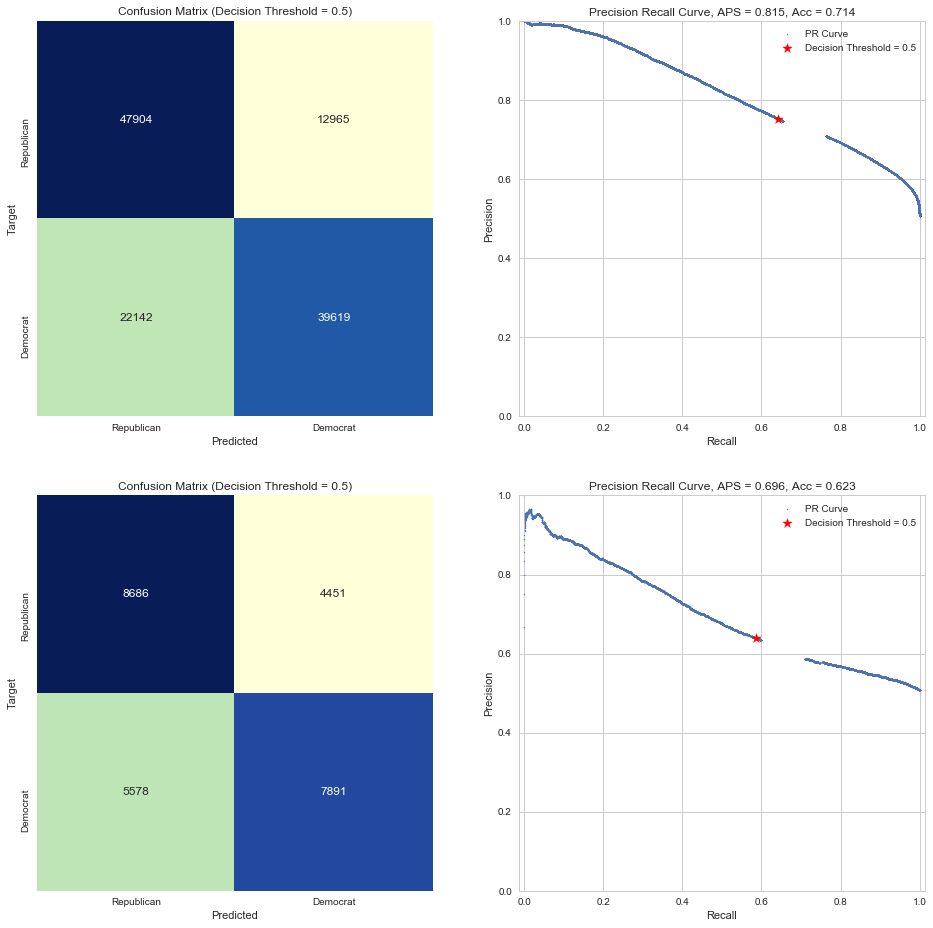

In [40]:
f, ax = plt.subplots(2, 2, figsize=(16,16))
evaluate_model(X_train, y_train, lgb, ax[0])
evaluate_model(X_test, y_test, lgb, ax[1])

# SVM

### TFIDF

C:\Users\Gustav\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


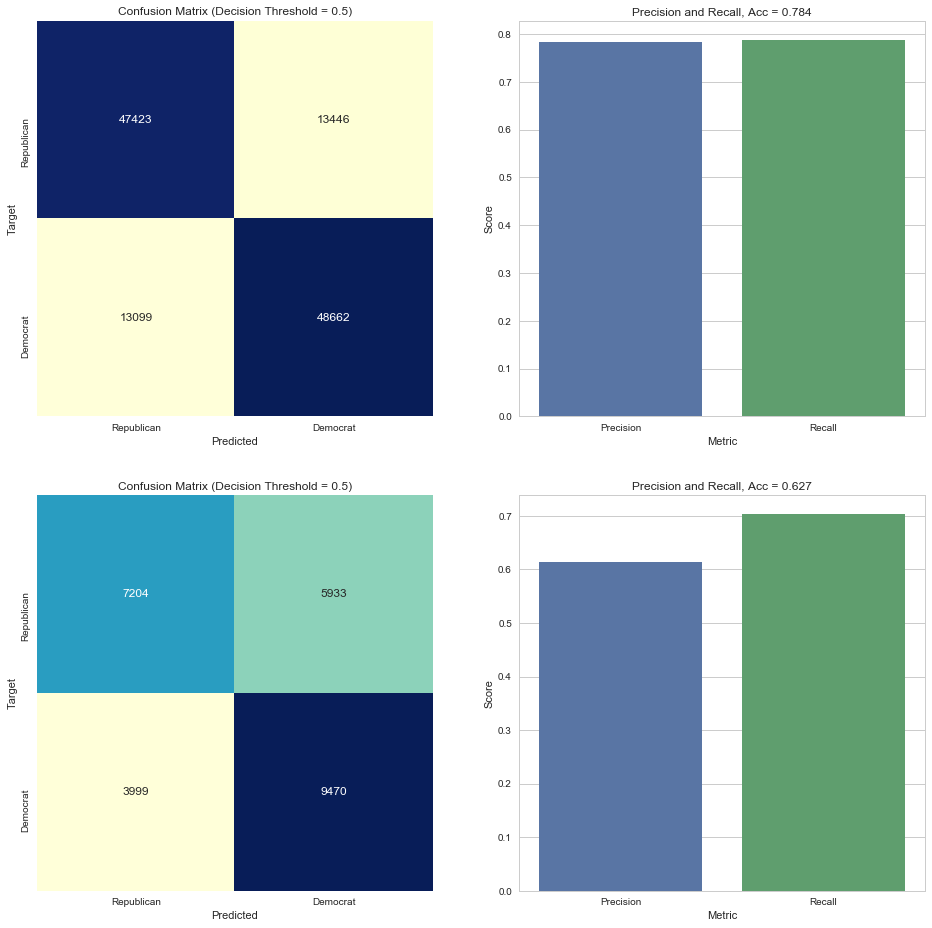

In [43]:
from sklearn.svm import LinearSVC
svm = LinearSVC()
svm.fit(X_train, y_train)

f, ax = plt.subplots(2, 2, figsize=(16,16))
evaluate_model(X_train, y_train, svm, ax[0], plot_pr_curve=False)
evaluate_model(X_test, y_test, svm, ax[1], plot_pr_curve=False)

# Random Forest

## TFIDF

In [44]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
random_forest = RandomForestClassifier(min_samples_split =  0.005, n_estimators = 400)
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.005,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

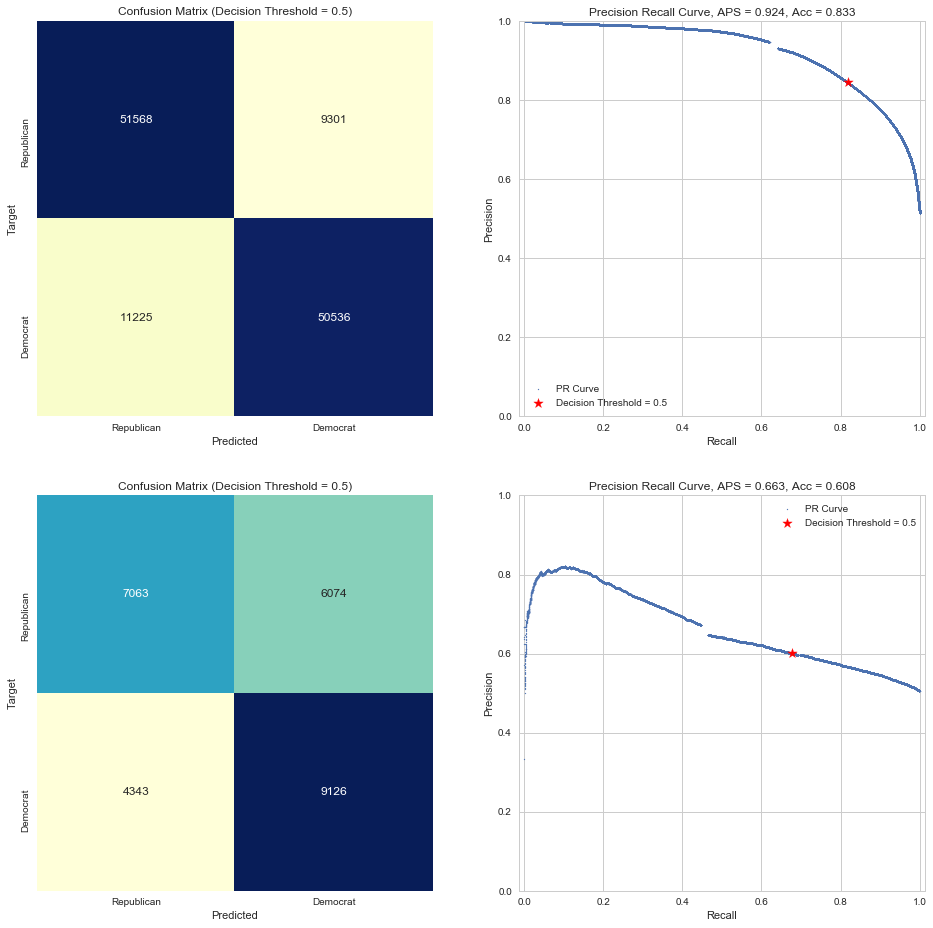

In [46]:
f, ax = plt.subplots(2, 2, figsize=(16,16))
evaluate_model(X_train, y_train, random_forest, ax[0])
evaluate_model(X_test, y_test, random_forest, ax[1])